# Environment

In [ ]:
!pip install implicit
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib

# User Modeling

In [1]:
import numpy as np
import math
class UserModel:

    def __init__(self, user_num, startup_iter, new_item_num_per_iter=10, iter=1000, vec_dim=20):
        self.user_num = user_num
        self.startup_iter = startup_iter
        self.startup = True
        self.new_item_num_per_iter = new_item_num_per_iter
        self.item_num = new_item_num_per_iter * iter
        self.iter_num = iter
        mu_user = 10 * np.random.dirichlet(np.ones(vec_dim))
        mu_item = 0.1 * np.random.dirichlet(np.ones(vec_dim) * 100)
        self.user_vec = np.array([np.random.dirichlet(mu_user) for _ in range(user_num)])
        self.item_vec = np.array([np.random.dirichlet(mu_item) for _ in range(self.item_num)])

        def alt_beta(mean, std=1e-5):
            try:
                alpha = math.pow(mean, 2) * (((1 - mean) / math.pow(std, 2)) - (1 / mean))
                beta = alpha * ((1 / mean) - 1)
                return np.random.beta(alpha, beta)
            except:
                return mean

        _beta_func = np.vectorize(alt_beta)
        row_utility = _beta_func(np.matmul(self.user_vec, self.item_vec.T))
        proportion = _beta_func(0.98 * np.ones(row_utility.shape))
        self.utility = row_utility * proportion
        self.iter = -1
        self.new_item = []
        self.selected = np.zeros([1, self.user_num, self.item_num])
        self.model_num = 0
        self.new_iter()

    def new_iter(self):
        if self.iter < self.item_num - 1:
            self.iter += 1
            self.new_item = np.array([i for i in range(self.iter * 10, self.iter * 10 + 10)])
            np.random.shuffle(self.new_item)
            if self.iter >= self.startup_iter:
                self.startup = False

    def add_model(self):
        self.model_num += 1
        if self.model_num != 1:
            self.selected = np.concatenate((self.selected, np.zeros([1, self.user_num, self.item_num])), axis=0)
        return self.model_num - 1

    def interleave(self, rank_list):
        _tmp = rank_list[10:]
        interleaved = np.array([])
        for i in range(10):
            interleaved = np.append(interleaved, rank_list[i])
            interleaved = np.append(interleaved, self.new_item[i])
        return np.append(interleaved, _tmp)

    def recommend_oneuser(self, rank_list, u, model_idx):
        if self.startup:
            rank_list = self.new_item
        else:
            rank_list = np.array(rank_list)
            #rank_list = self.interleave(rank_list)
        select_item = -1
        max_score = 0
        for r, i in enumerate(rank_list):
            score = math.pow(r + 1, -0.8) * self.utility[u, i]
            if score > max_score and not self.selected[model_idx, u, i]:
                max_score = score
                select_item = i

        self.selected[model_idx, u, select_item] = 1
        return select_item

    def recommend(self, rank_list, model_idx):
        #rank_list = list(rank_list)
        return [self.recommend_oneuser(r_list, u, model_idx) for u, r_list in enumerate(rank_list)]

# User Modeling Config

In [2]:
###### User Modeling Initialization ######
startup_iter = 1000
user_num = 100
test = UserModel(user_num, startup_iter)
idx = test.add_model() # assume there's only one model now

###### start-up ######
while test.startup:
    test.recommend([None]*user_num, idx)
    test.new_iter()

# Visualize user-item table

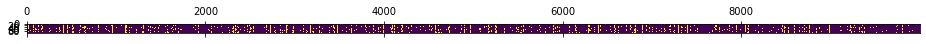

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def visualize(user_item_table):
    plt.matshow(user_item_table)
    plt.show()
visualize(test.selected[idx])

# Train the Model

In [4]:
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

def data_loader(user_item_table):
    np.random.seed(1234)
    user_item_csr = csr_matrix(user_item_table)
    user_item_train, user_item_test = train_test_split(user_item_csr, train_percentage=0.8)
    return user_item_train, user_item_test

In [8]:
###### Get data & Train Model######
## Train
user_item_table = test.selected[idx]
def train(user_item_table, bpr=None):
    user_item_train, user_item_test = data_loader(user_item_table)
    np.random.seed(1234)

    if bpr:
        bpr.fit(user_item_train.T.tocsr())
    else:
        bpr = BayesianPersonalizedRanking(iterations=100)
        bpr.fit(user_item_train.T.tocsr()) 
    return bpr
bpr = train(user_item_table,None)

GPU training requires factor size to be a multiple of 32 - 1. Increasing factors from 100 to 127.


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
def recommend_all(bpr, user_item_table, user_num, top_k):
    rank_list = list()    
    for user_id in range(user_num):
        reco = bpr.recommend(user_id, user_item_table, N=top_k, filter_already_liked_items=True)
        single_rank_list = [element[0] for element in reco]
        rank_list.append(single_rank_list)
    return rank_list

  0%|          | 0/100 [00:00<?, ?it/s]

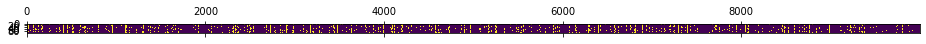

  0%|          | 0/100 [00:00<?, ?it/s]

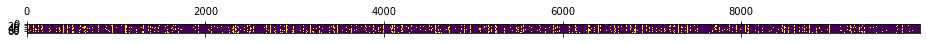

  0%|          | 0/100 [00:00<?, ?it/s]

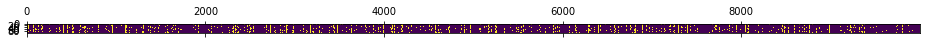

  0%|          | 0/100 [00:00<?, ?it/s]

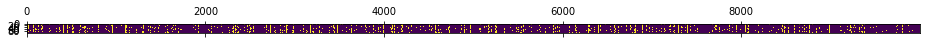

  0%|          | 0/100 [00:00<?, ?it/s]

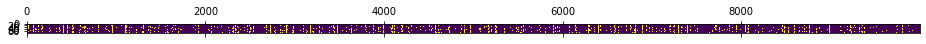

  0%|          | 0/100 [00:00<?, ?it/s]

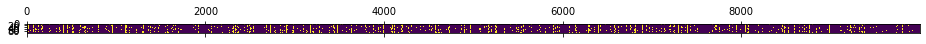

  0%|          | 0/100 [00:00<?, ?it/s]

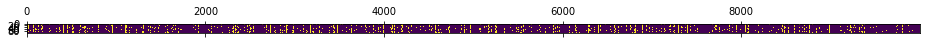

  0%|          | 0/100 [00:00<?, ?it/s]

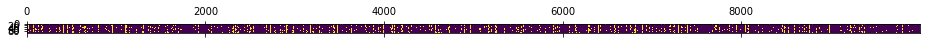

  0%|          | 0/100 [00:00<?, ?it/s]

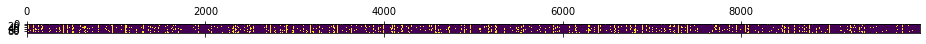

  0%|          | 0/100 [00:00<?, ?it/s]

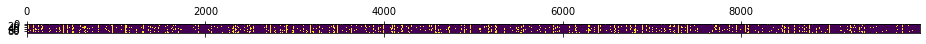

In [10]:
###### User Feedback(Interaction) & Retrain The Model ######
feedback_iteration = 10
for i in range(feedback_iteration):
    ## Inference
    old_user_item_table = test.selected[idx].copy()
    top_k = 20 # assume recommend 30 items to each user
    rank_list = recommend_all(bpr, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)
    
    ## User Interaction
    test.recommend(rank_list, model_idx=idx)
    new_user_item_table = test.selected[idx].copy()
    
    ## Retrain Model
    #diff_user_item_table = new_user_item_table - old_user_item_table
    bpr = train(new_user_item_table, bpr)
    
    visualize(new_user_item_table)